# DL project - classifying emotions from facial images
*Group 17 - Dorothy Modrall Sperling, Manuel Schönberger, Lea Roncero*

https://github.com/shivamsingh96/Facial-Expression-Detection-using-CNN-Real-Time-Recognition-with-Webcam/blob/main/Real-Time%20Facial%20Expression%20Detection%20%26%20Recognition%20using%20CNN.ipynb

## 0. Dataset description

For our deep learning project, we use the FER+ dataset that contains ~28.700 pictures of facial expressions and was proposed in the assignment specification.

###  Features of the Dataset

**Emotion**
- Represents the class label for the facial expression depicted in the image.
- It is an integer value ranging from `0` to `6`, corresponding to seven different emotions:
  - `0`: Angry  
  - `1`: Disgust  
  - `2`: Fear  
  - `3`: Happy  
  - `4`: Sad  
  - `5`: Surprise  
  - `6`: Neutral  

**Pixels**
- A string of pixel values representing a `48x48` grayscale image.
- Contains `2304` comma-separated values (`48 x 48 = 2304`), where each value is an intensity level in the range `0-255`.

## 1. Importing libraries and loading the data

In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import pandas as pd


First, we load the data into a pandas dataframe.

In [2]:
train_unprocessed= pd.read_csv("data/train.csv")
print(train_unprocessed.head(10))

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8        3  85 84 90 121 101 102 133 153 153 169 177 189 1...
9        2  255 254 255 254 254 179 122 107 95 124 149 150...


In [3]:
# Checking Shape of data
train_unprocessed.shape

(28709, 2)

## 2. Data Visualization

In [4]:
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_labels

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

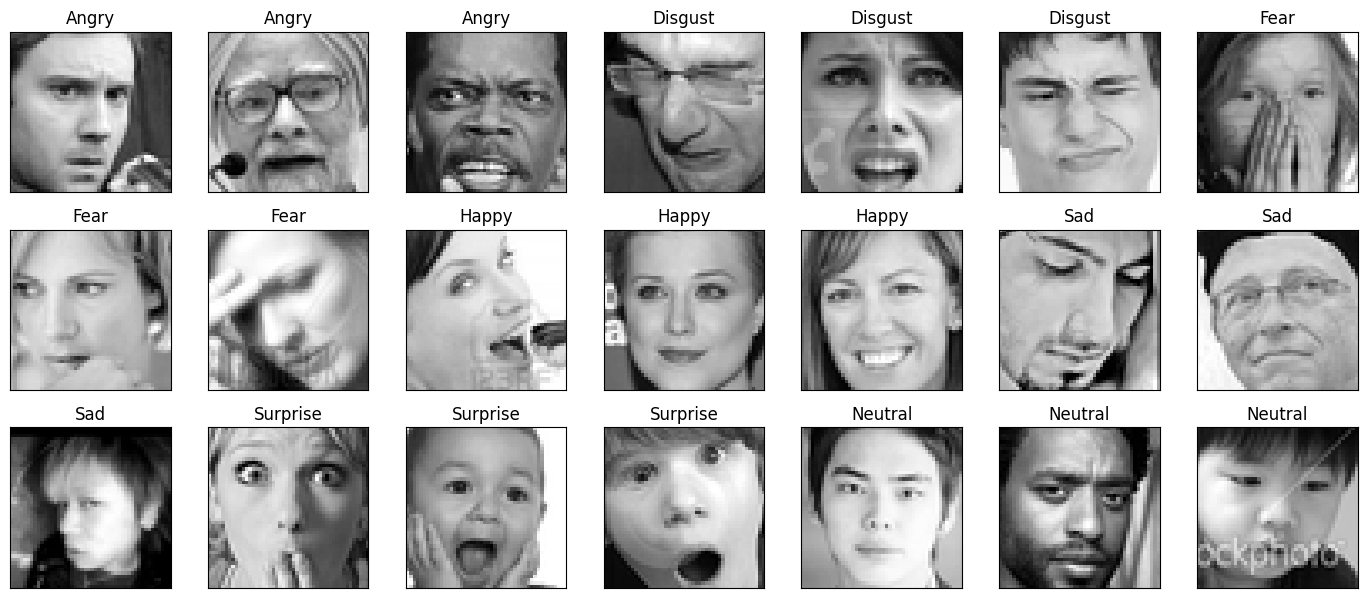

In [5]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(train_unprocessed.emotion.unique()):
    for j in range(3):
        px = train_unprocessed[train_unprocessed.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_labels[label])
        plt.tight_layout()

Next, we check the emotion class distribution

emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64


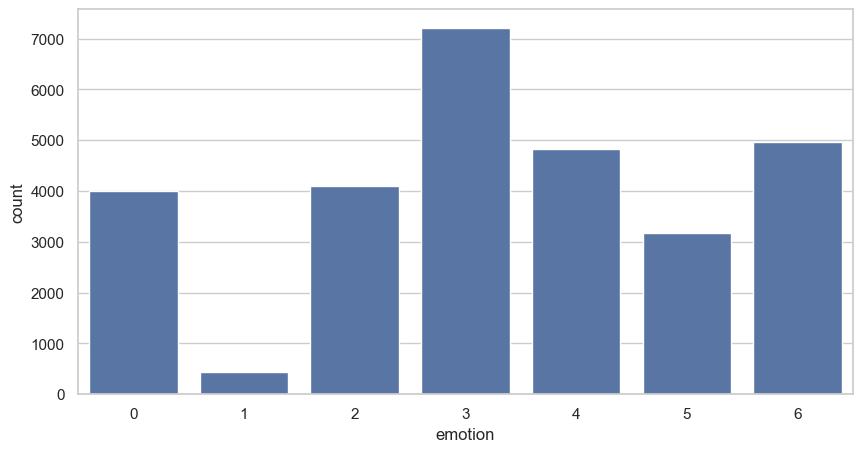

In [6]:
# Checking value counts
print(train_unprocessed['emotion'].value_counts())

# Plotting the above distribution
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="emotion", data=train_unprocessed)

From the above chart, we can observe that the data is highly imbalnace and that for some emotions we have a very small number of images.

## 3. Preprocessing data

The cell below shows that there are no missing values. It is therefore not necessary to impute anything.

In [7]:
train_unprocessed.isnull().values.any()

False

However, as we have seen before, the data is highly inbalanced. Therefore, we first over-sample the minority classes using RandomOverSampler so that the emotion classes are evenly distributed

In [8]:
# Split the data into feature & target variable
x_data = train_unprocessed['pixels']
y_data = train_unprocessed['emotion']

oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)

# Convert oversampled data back to a DataFrame for compatibility with the dataset
x_data = pd.DataFrame(x_data, columns=["pixels"])
y_data = pd.Series(y_data, name="emotion")
oversampled_data = pd.concat([x_data, y_data], axis=1)

# Shuffle the oversampled dataset to mix the examples
oversampled_data = shuffle(oversampled_data)

print(oversampled_data.shape)
print(oversampled_data['emotion'].value_counts())

(50505, 2)
emotion
2    7215
3    7215
0    7215
1    7215
5    7215
6    7215
4    7215
Name: count, dtype: int64


We also apply the following preprocessing steps to convert the data into the desired format we can further work with:
1. **Reshaping**:
   - Convert the pixel string into a `48x48` matrix for visualization and processing.
2. **Scaling**:
   - Scale pixel values to the range `[0, 1]` by dividing the pixel values by 255.
3. **Normalization**:
   - Normalize pixel values to the range `[-1, 1]` by subtracting the mean and diving them by the standard deviation.

In [9]:
class ReshapeAndScale:
    def __init__(self, n_rows, n_cols):
        self.n_rows = n_rows
        self.n_cols = n_cols

    def __call__(self, pixel_string):
        # Reshape the flat pixel string into a 2D array
        pixel_vals = np.array([float(val) for val in pixel_string.split()], dtype=np.float32)
        image = pixel_vals.reshape(self.n_rows, self.n_cols)

        # Scale the image to [0, 1]
        image = image / 255.0

        # Convert to a PyTorch tensor
        return torch.tensor(image, dtype=torch.float32).unsqueeze(0) # add a channel dimension

# Define the pipeline
transform = transforms.Compose([
    ReshapeAndScale(n_rows=48, n_cols=48),
    # transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    # transforms.RandomRotation(degrees=15),  # Rotate images by up to 15 degrees
    # transforms.RandomCrop(size=(48, 48), padding=4),  # Crop with padding
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

## 4. Define a custom dataset

In [10]:
from torch.utils.data import Dataset

class Fer2013Dataset(Dataset):
    def __init__(self, data_frame, labels, transform=None):
        self.data_frame = data_frame
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        pixel_string = self.data_frame.iloc[idx]["pixels"]
        image = self.transform(pixel_string) if self.transform else pixel_string

        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return image, label

    def __len__(self):
        return len(self.data_frame)

In [11]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

batch_size = 32

full_dataset = Fer2013Dataset(oversampled_data, oversampled_data['emotion'], transform=transform)

train_dataset, val_dataset = random_split(full_dataset, [0.8, 0.2])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for batch_images, batch_labels in train_loader:
    print("Train Batch Shape:", batch_images.shape, "Train Labels Shape:", batch_labels.shape)

for batch_images, batch_labels in val_loader:
    print("Validation Batch Shape:", batch_images.shape, "Validation Labels Shape:", batch_labels.shape)


Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Siz

## 5. Define the CNN model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 1st Conv Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='valid')
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.25)

        # 2nd Conv Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Conv Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='valid')
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.25)

        # 4th Conv Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 5th Conv Layer
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='valid')
        self.bn5 = nn.BatchNorm2d(128)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flatten size dynamically
        self.flatten_size = self._get_flatten_size()

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.flatten_size, 250)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(250, 7)  # 7 classes for emotion recognition

    def _get_flatten_size(self):
        # Create a dummy tensor with the same size as input image
        dummy_input = torch.zeros(1, 1, 48, 48)  # batch_size, channels, height, width
        dummy_output = self._forward_conv_layers(dummy_input)
        return dummy_output.numel()

    def _forward_conv_layers(self, x):
        # Pass through convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool5(x)

        return x

    def forward(self, x):
        # Use the convolutional layers defined in _forward_conv_layers
        x = self._forward_conv_layers(x)

        # Dynamically flatten the output
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model = model.to(device)

# Print model to verify layers
print(model)


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=val

## 4. Define Loss Function and Optimizer

In [13]:
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # call optimizer

## 5. Train the Model

In [ ]:
num_epochs = 35  # define number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

Epoch [1/35], Step [100/1263], Loss: 1.9516
Epoch [1/35], Step [200/1263], Loss: 1.8983
Epoch [1/35], Step [300/1263], Loss: 1.8463
Epoch [1/35], Step [400/1263], Loss: 1.8023
Epoch [1/35], Step [500/1263], Loss: 1.7652
Epoch [1/35], Step [600/1263], Loss: 1.7491
Epoch [1/35], Step [700/1263], Loss: 1.7335
Epoch [1/35], Step [800/1263], Loss: 1.6717
Epoch [1/35], Step [900/1263], Loss: 1.6367
Epoch [1/35], Step [1000/1263], Loss: 1.5744
Epoch [1/35], Step [1100/1263], Loss: 1.5549


## 6. Evaluate the Model

In [ ]:
from sklearn.metrics import classification_report

# Switch model to evaluation mode
model.eval()

# Initialize lists to store ground truth and predictions
y_true, y_pred = [], []

# Disable gradient computation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Append ground truth and predictions to respective lists
        y_true.extend(labels.cpu().numpy())  # Convert tensors to numpy
        y_pred.extend(predicted.cpu().numpy())

# Generate the classification report
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))


              precision    recall  f1-score   support

       Angry       0.64      0.47      0.54      1407
     Disgust       0.84      0.99      0.91      1383
        Fear       0.59      0.23      0.33      1471
       Happy       0.74      0.81      0.78      1475
         Sad       0.44      0.61      0.51      1446
    Surprise       0.79      0.78      0.79      1452
     Neutral       0.53      0.67      0.59      1467

    accuracy                           0.65     10101
   macro avg       0.65      0.65      0.64     10101
weighted avg       0.65      0.65      0.63     10101



History:

```
num_epochs = 5
```


```
transform = transforms.Compose([
    ReshapeAndScale(n_rows=48, n_cols=48),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.RandomRotation(degrees=15),  # Rotate images by up to 15 degrees
    transforms.RandomCrop(size=(48, 48), padding=4),  # Crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small random translations
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])
```

```
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_data), y=y_data)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Use AdamW with weight decay
```

```
batch_size = 16
```

Accuracy = 0.47

```
batch_size = 32
```

Accuracy = 0.47

```
batch_size = 64
```

Accuracy = 0.43

```
num_epochs = 35
```

Accuracy = 0.61


```
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
```

```
batch_size = 32
```

```
num_epochs = 50
```

Accuracy = nA